# Solving an implicit equation using <font size=5>[`PiecewiseHilbert`](https://christopheberthod.github.io/Piecewise.jl/dev/hilbert.html)</font>

**[`Piecewise`](https://github.com/ChristopheBerthod/Piecewise.jl)** *Tutorial 2*<br>
25-02-2025 | Christophe Berthod | University of Geneva, Switzerland

<div class="alert alert-block alert-success">This notebook can run on a laptop. It will typically take a few minutes to evaluate all cells on a single thread. A recent version of <a href="https://julialang.org" style="text-decoration:none"><code>Julia</code></a> is needed, complemented by the packages
<a href="https://github.com/JuliaMath/SpecialFunctions.jl" style="text-decoration:none"><code>SpecialFunctions</code></a>,
<a href="https://github.com/ChristopheBerthod/Piecewise.jl" style="text-decoration:none"><code>Piecewise</code></a>,
<a href="https://github.com/ChristopheBerthod/Piecewise.jl" style="text-decoration:none"><code>PiecewiseHilbert</code></a>, and
<a href="https://github.com/JuliaMath/QuadGK.jl" style="text-decoration:none"><code>QuadGK</code></a>
for the math, as well as
<a href="https://github.com/JuliaPlots/Plots.jl" style="text-decoration:none"><code>Plots</code></a>,
<a href="https://github.com/JuliaStrings/LaTeXStrings.jl" style="text-decoration:none"><code>LaTeXStrings</code></a>, and
<a href="https://github.com/JuliaGraphics/Measures.jl" style="text-decoration:none"><code>Measures</code></a>
for plotting purposes.</div>

In [1]:
# Packages used in this notebook

using SpecialFunctions
using Piecewise, PiecewiseHilbert
using QuadGK
using Plots, LaTeXStrings, Measures
using Printf

**Context** – The electrons do not behave like tiny hard balls: when they hit obstacles or other electrons, they can sometimes disappear – more precisely they dissolve, so to say, into something else. As a result, an electron injected in a piece of matter lives for a finite amount of time, after which it will have disappeared with a high probability. In the quantum theory, this finite lifetime is captured by a complex-valued quantity called the *self-energy* and usually denoted by the greek letter $\Sigma$. The self-energy depends on the energy $\varepsilon$ of the electron. If the electrons were not interacting with obstacles and other electrons, there would be a relation $\varepsilon(\mathbf{k})$ called dispersion relation between their energy and their wavevector, as described in [*Tutorial 1*](https://github.com/ChristopheBerthod/Piecewise.jl/notebooks/Tutorial-1.ipynb). The interactions destroy this relation, and as a result the self-energy depends in general separately on the energy $\varepsilon$ and the wavevector $\mathbf{k}$ of the electron. There exists a family of theories dubbed *local*, though, where the self-energy only depends on $\varepsilon$, not on $\mathbf{k}$. One such theory describes some of the effects of structural disorder on the electrons and is called the *self-consistent Born approximation*. In this theory, the self-energy is given by the implicit equation
$$\Sigma(\varepsilon)=g^2\int_{-\infty}^{\infty}dE\,\frac{N(E)}{\varepsilon-E-\Sigma(\varepsilon)},$$
where $g$ is a *coupling constant*, i.e., a number quantifying the strength of the disorder and $N(E)$ is the density of states (DOS) corresponding to the noninteracting dispersion relation $\varepsilon(\mathbf{k})$. We have seen in [*Tutorial 1*](https://github.com/ChristopheBerthod/Piecewise.jl/notebooks/Tutorial-1.ipynb) how to construct accurate piecewise approximations for the DOS $N(E)$. Here, we will see how to obtain $\Sigma(\varepsilon)$ using [`Piecewise`](https://github.com/ChristopheBerthod/Piecewise.jl) and [`PiecewiseHilbert`](https://github.com/ChristopheBerthod/Piecewise.jl).

**Contents of the notebook** – In a first section, we solve the implicit equation for $\Sigma(\varepsilon)$ using quadratures on the one hand and piecewise functions on the other hand, and we compare the two solutions. In a second section, we construct a peicewise function that reproduces the solution $\Sigma(\varepsilon)$.

## Solving the implicit equation

The Hilbert transform of the DOS $N(E)$ is $(H\circ N)(z)=\int_{-\infty}^{\infty}dE\,\frac{N(E)}{z-E}$. The implicit equation for the self-energy $\Sigma(\varepsilon)$ can therefore be rewritten as
$$\Sigma(\varepsilon)=g^2(H\circ N)\big(\varepsilon-\Sigma(\varepsilon)\big).$$
We will solve this equation in the case of the anisotropic square lattice treated in [*Tutorial 1*](https://github.com/ChristopheBerthod/Piecewise.jl/notebooks/Tutorial-1.ipynb), where $\varepsilon(\mathbf{k})=2(\cos k_x+\alpha\cos k_y)$. We first proceed without using piecewise functions, such that the evaluation of $N(E)$ requires a one-dimensional quadrature and the evaluation of $(H\circ N)(z)$ requires another quadrature.

### Solution using quadratures

We use the same code as in [*Tutorial 1*](https://github.com/ChristopheBerthod/Piecewise.jl/notebooks/Tutorial-1.ipynb) for the DOS and we define a function `Hof` that takes a function $f(x)$ as argument and computes its Hilbert transform at $z$. Although the default relative tolerance for the DOS and Hilbert-transform quadratures is set to $10^{-8}$, we will use `tol=4e-5` later on, in order to work at the same accuracy as the accuracy of the piecewise approximations that we will be using, for a fair comparison of the timings.

In [2]:
# DOS function (from Tutorial-1)
function N(E, α; tol=1e-8)
    # No integral to perform if |E| >= 2 * (1 + α)
    abs(E) < 2 * (1 + α) || return 0.0
    # !! 1 - (E / 2 - α * cos(θ))^2 could be 0.0 due to rounding errors
    integrand(θ) = 1 / sqrt(abs(1 - (E / 2 - α * cos(θ))^2) + eps(Float64))
    int = quadgk(integrand, acos(min(1, (E / 2 + 1) / α)), acos(max(-1, (E / 2 - 1) / α)); rtol = tol / 10)
    if int[2] / int[1] > tol
        e = @sprintf("%.1e", int[2] / int[1])
        @warn "Integral not converged in N($(E), $(α); tol=$(tol)) [error = $(e)]"
    end
    return int[1] / (2 * π^2)
end

# Hilbert transform of the function f by quadratures
function Hof(f, z; x1=-Inf, x2=Inf, tol=1e-8)
    int = quadgk(x -> f(x) / (z - x), x1, x2, rtol=tol / 10)
    if abs(int[2] / int[1]) > tol
        e = @sprintf("%.1e", abs(int[2] / int[1]))
        @warn "Integral not converged in Hof(f, $(z); x1=$(x1), x2=$(x2), tol=$(tol)) [error = $(e)]"
    end
    return int[1]
end
;

We now perform an iterative search to compute the self-energy. If $\Sigma(\varepsilon)$ has not converged within $10^{-12}$ after 10000 iterations, we reduce the accuracy and optionally give a warning.

In [3]:
# Self-consistent Born self-energy by quadratures
function Σ(g, α::Real, ε; tol=1e-8, atol=1e-12, warn=true)
    # Hilbert transform of the DOS
    HoN(z) = Hof(E -> N(E, α, tol=tol), z; x1=-2 * (1 + α), x2=2 * (1 + α), tol=tol)
    # Initialization
    Σold, Σnew, i, s = -im, g^2 * HoN(ε + im), 0, 1
    # Search loop
    while abs(Σnew - Σold) > s * atol
        i += 1
        i % 10000 == 0 && (s *= 10)
        Σold, Σnew = Σnew, g^2 * HoN(ε - Σnew)
    end
    s > 1 && warn && @warn("Loss of precision for ε = $(ε) [$(s * atol)]")
    return Σnew
end

# Result for g = 0.2, α = 0.2, and ε = 0
Σ(0.2, 0.2, 0.0, tol=4e-5)

9.962031199961532e-15 - 0.020203509233998936im

### Solution using <font size=3>[`Piecewise`](https://github.com/ChristopheBerthod/Piecewise.jl)</font> and <font size=3>[`PiecewiseHilbert`](https://github.com/ChristopheBerthod/Piecewise.jl)</font>

We proceed like in [*Tutorial 1*](https://github.com/ChristopheBerthod/Piecewise.jl/notebooks/Tutorial-1.ipynb) to construct a piecewise approximation for the DOS at $\alpha=0.2$, with an accuracy of $\sim 4\times 10^{-5}$. We then create the [`HilbertTransform`](https://christopheberthod.github.io/Piecewise.jl/dev/hilbert.html#PiecewiseHilbert.HilbertTransform) object holding the Hilbert transform of that approximation.

In [4]:
# Piecewise function representing the logarithmic singularity
function singularityα(α)
    s, b = 2 * (1 - α), 2 * (1 + α)
    return PiecewiseFunction(:even, [
        Piece((0, s), (true, false), LOG, [s, -1 / (4 * π^2 * sqrt(α))]),
        Piece((s, b), (false, true), LOG, [s, -1 / (4 * π^2 * sqrt(α))])
        ])
end

α = 0.2
f = piecewisefit(E -> N(E, α) - singularityα(α)(E), (0, 2 * (1 + α)),
    [POLY, TAIL], parity=:even, cuts=[1.56, 1.6, 1.62], rtol=1e-4) + singularityα(α)

# Hilbert transform of the PiecewiseFunction f
HoN = HilbertTransform(f)

┌ Warning: Integral not converged in N(1.6000001192092896, 0.2; tol=1.0e-8) [error = 5.9e-08]
└ @ Main In[2]:10


< Hilbert transform of even piecewise function with support [-2.4, 2.4] >

We can then perform the iterative search using `HoN`:

In [5]:
# Self-consistent Born self-energy using PiecewiseHilbert
function Σ(g, HoN::HilbertTransform, ε; atol=1e-12, warn=true)
    Σold, Σnew, i, α = -im, g^2 * HoN(ε + im), 0, 1
    while abs(Σnew - Σold) > α * atol
        i += 1
        i % 10000 == 0 && (α *= 10)
        Σold, Σnew = Σnew, g^2 * HoN(ε - Σnew)
    end
    α > 1 && warn && @warn("Loss of precision for ε = $(ε) [$(α * atol)]")
    return Σnew
end

# Result for g = 0.2, α = 0.2, and ε = 0
Σ(0.2, HoN, 0.0)

0.0 - 0.020203950469273403im

### Comparison of the two solutions

In the left graph below, the thick-blue and thick-red lines show the real and imaginary parts of $\Sigma(\varepsilon)$, respectively, calculated using quadratures, while the thin white lines show the result obtained using piecewise functions. The right graph shows that the absolute value of the relative difference is less that $4\times10^{-5}$, i.e., less than the accuracy of the DOS and its piecewise approximation.

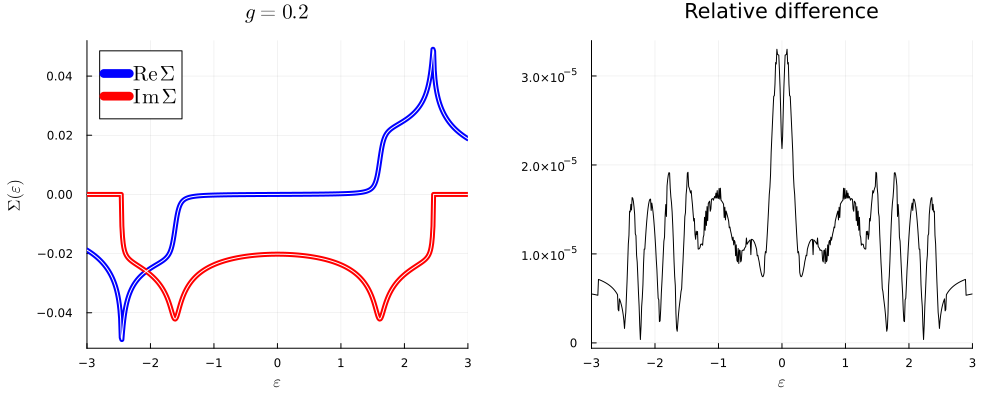

In [6]:
α = 0.2
g = 0.2
ε = -3:0.01:3

p1 = plot(xlabel=L"\varepsilon", xlim=(-3, 3), ylabel=L"\Sigma(\varepsilon)",
    legend=:topleft, legendfontsize=14, title=latexstring("g = $(g)"))
plot!(p1, ε, real.(Σ.(g, α, ε, tol=4e-5)), lw=5, c=:blue, label=L"\mathrm{Re}\,\Sigma")
plot!(p1, ε, imag.(Σ.(g, α, ε, tol=4e-5)), lw=5, c=:red, label=L"\mathrm{Im}\,\Sigma")
plot!(p1, ε, real.(Σ.(g, HoN, ε)), lw=1, c=:white, label=:none)
plot!(p1, ε, imag.(Σ.(g, HoN, ε)), lw=1, c=:white, label=:none)

p2 = plot(xlabel=L"\varepsilon", xlim=(-3, 3),
    legend=:none, title="Relative difference")
plot!(p2, ε, abs.(Σ.(g, HoN, ε) ./ Σ.(g, α, ε, tol=4e-5) .- 1), lw=1, c=:black)

plot(p1, p2, size = (1000, 400), margins=5mm)

With the chosen parameters, the piecewise-approximation method is as precise as the quadrature method, but roughly 20 times faster.

In [7]:
@time Σ.(g, α, ε, tol=4e-5);
@time Σ.(g, HoN, ε);

 27.682930 seconds (14.36 M allocations: 4.330 GiB, 1.82% gc time, 0.23% compilation time)
  1.390593 seconds (7.54 M allocations: 222.787 MiB, 1.55% gc time, 4.73% compilation time)


## Piecewise representation of the solution

In a calculation where both $N(E)$ and $\Sigma(\varepsilon)$ appear inside integrals and must be evaluated many times (see, e.g., [`MagnetoTransport.jl`](https://christopheberthod.github.io/MagnetoTransport.jl/dev/index.html#MagnetoTransport.jl)), it is convenient to have piecewise approximations for both of them. Since $\Sigma(\varepsilon)$ is complex-valued, we could piecewise-fit both the real and imaginary parts. There exists a better approach, though, because $\Sigma(\varepsilon)$ is *causal*, i.e., its real and imaginary parts are not independent, but related by [Kramers-Kronig relations](https://en.wikipedia.org/wiki/Kramers%E2%80%93Kronig_relations). These relations can be summarized as follows:
$$\Sigma(\varepsilon)=\int_{-\infty}^{\infty}d\varepsilon'\,\frac{-\frac{1}{\pi}\mathrm{Im}\,\Sigma(\varepsilon')}{\varepsilon-\varepsilon'+i0^+}=(H\circ\Gamma)(\varepsilon+i0^+),\qquad \Gamma(\varepsilon)\doteqdot-\frac{1}{\pi}\mathrm{Im}\,\Sigma(\varepsilon).$$
The real quantity $\Gamma(\varepsilon)$ – which is inversely proportional to the electron lifetime – allows one to reconstruct the complex quantity $\Sigma(\varepsilon)$. Our approach will therefore be to piecewise-fit $\Gamma(\varepsilon)$ and use [`PiecewiseHilbert`](https://github.com/ChristopheBerthod/Piecewise.jl) for constructing a [`HilbertTransform`](https://christopheberthod.github.io/Piecewise.jl/dev/hilbert.html#PiecewiseHilbert.HilbertTransform) object that directly gives $\Sigma(\varepsilon)$.

The mathematical study of $\Gamma(\varepsilon)$ shows that it vanishes as a square root at some energy $\varepsilon_0$. The left graph below shows this square-root edge. Since a square-root edge is a non-analytic feature that can be described by the [`Formula`](https://christopheberthod.github.io/Piecewise.jl/dev/index.html#Piecewise.Formula) [`PLS`](https://christopheberthod.github.io/Piecewise.jl/dev/index.html#PLS), it is better to subtract this edge before fitting. We perform a bisection that finds $\varepsilon_0$ for $g=0.2$, show the extracted edge in the left graph and the function passed to [`piecewisefit`](https://christopheberthod.github.io/Piecewise.jl/dev/index.html#Piecewise.piecewisefit) in the right graph.

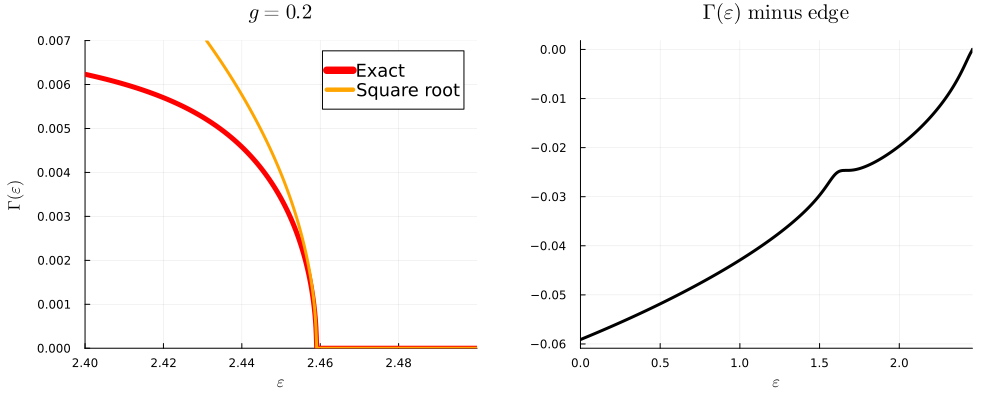

In [8]:
Gamma(ε) = -imag(Σ(g, HoN, ε)) / π

# Function to determine the edge
function find_edge(tol)
    x1, x2 = 2.4, 2.5
    f1, f2 = Gamma(x1), Gamma(x2)
    while abs(x2 - x1) > tol
		x3 = (x1 + x2) / 2; f3 = Gamma(x3)
		if f3 > 1e-10
		    x1, f1 = x3, f3
		else
		    x2, f2 = x3, f3
		end
    end
    return (x1 + x2) / 2
end

# Location of the edge and amplitude of the square root
ε₀ = find_edge(1e-4)
A  = Gamma(ε₀ - 1e-4) / sqrt(1e-4)

# Piecewise function representing the edge
edge = PiecewiseFunction(:even, Piece((0, ε₀), (true, false), PLS, [ε₀, 1 / 2, A]))

# Graphs
ε = 2.4:0.0001:2.5
p1 = plot(xlabel=L"\varepsilon", xlim=(2.4, 2.5), ylabel=L"\Gamma(\varepsilon)", ylim=(0, 0.007),
    legend=:topright, legendfontsize=12, title=latexstring("g = $(g)"))
plot!(p1, ε, Gamma.(ε), lw=5, c=:red, label="Exact")
plot!(p1, ε, edge.(ε), lw=3, c=:orange, label="Square root")

ε = 0:0.001:ε₀
p2 = plot(xlabel=L"\varepsilon", xlim=(0, ε₀),
    legend=:none, title=L"\Gamma(\varepsilon)\mathrm{~minus~edge}")
plot!(p2, ε, Gamma.(ε) .- edge.(ε), lw=3, c=:black)

plot(p1, p2, size = (1000, 400), margins=5mm)

As the function to fit is rather smooth, we use only [`POLY`](https://christopheberthod.github.io/Piecewise.jl/dev/index.html#POLY) as the fitting [`Formula`](https://christopheberthod.github.io/Piecewise.jl/dev/index.html#Piecewise.Formula). With a couple of well-chosen `cuts` (some trial-and-error involved here), the piecewise function `Γ` should have a relative accuracy of $4\times10^{-5}$, consistently with the accuracy targeted so far.

In [9]:
# Fitting polynomials to the smooth part and adding the edge
Γ = piecewisefit(ε -> Gamma(ε) - edge(ε), (0, ε₀), [POLY], parity=:even, rtol=4e-5,
    cuts=[0.8, 0.9, 1, 1.2, 1.5, 1.56, 1.6], grain=1e-3) + edge

# Hilbert transform of Γ and corresponding self-energy
HoΓ  = HilbertTransform(Γ)
Σ(ε) = HoΓ(ε + im * eps(Float32))

┌ Warning: Loss of precision for ε = 2.4590330839157106 [1.0e-11]
└ @ Main In[5]:9
┌ Warning: Reached discretisation limit of 0.001 in domain (2.457355403900147, 2.4581943035125735)
└ @ Piecewise ~/.julia/packages/Piecewise/pTs0L/src/private-methods.jl:220
┌ Warning: Reached discretisation limit of 0.001 in domain (2.4581943035125735, 2.459033203125)
└ @ Piecewise ~/.julia/packages/Piecewise/pTs0L/src/private-methods.jl:220


Σ (generic function with 3 methods)

In the left graph below, the thick-blue and thick-red lines show the real and imaginary parts of $\Sigma(\varepsilon)$, respectively, calculated as in the previous section using piecewise function, while the thin white lines show the representation of the solution as the Hilbert transform of the fitted $\Gamma(\varepsilon)$. The right graph shows that the absolute value of the relative difference is indeed of order $4\times10^{-5}$ or less.

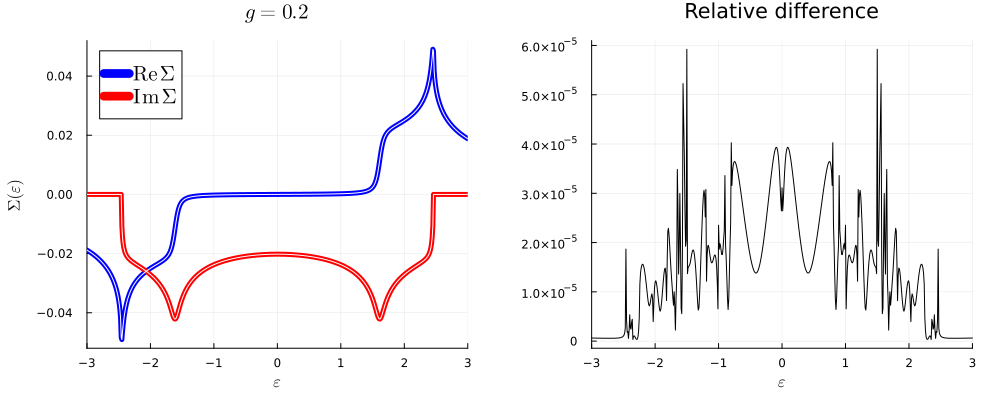

In [10]:
ε = -3:0.01:3

p1 = plot(xlabel=L"\varepsilon", xlim=(-3, 3), ylabel=L"\Sigma(\varepsilon)", legend=:topleft,
    legendfontsize=14, title=latexstring("g = $(g)"))
plot!(p1, ε, real.(Σ.(g, HoN, ε)), lw=5, c=:blue, label=L"\mathrm{Re}\,\Sigma")
plot!(p1, ε, imag.(Σ.(g, HoN, ε)), lw=5, c=:red, label=L"\mathrm{Im}\,\Sigma")
plot!(p1, ε, real.(Σ.(ε)), lw=1, c=:white, label=:none)
plot!(p1, ε, imag.(Σ.(ε)), lw=1, c=:white, label=:none)

p2 = plot(xlabel=L"\varepsilon", xlim=(-3, 3),
    legend=:none, title="Relative difference")
plot!(p2, ε, abs.(Σ.(ε) ./ Σ.(g, HoN, ε) .- 1), lw=1, c=:black)

plot(p1, p2, size = (1000, 400), margins=5mm)

In conclusion, we now have three ways of evaluating $\Sigma(\varepsilon)$ with an accuracy of $\sim4\times10^{-5}$. The slowest uses quadratures and does not require any pre-computation. The second requires a prior fitting of the DOS to a piecewise function, but then is faster by a factor 20. Finally, the third method relies on a prior piecewise fit of $\mathrm{Im}\,\Sigma(\varepsilon)$ and then saves an additional factor 2 in execution time.

In [11]:
@time Σ.(g, α, ε, tol=4e-5);
@time Σ.(g, HoN, ε);
@time Σ.(ε);

 28.205683 seconds (14.24 M allocations: 4.324 GiB, 1.84% gc time)
  1.365473 seconds (7.43 M allocations: 217.045 MiB, 1.87% gc time)
  0.815103 seconds (4.30 M allocations: 125.350 MiB, 1.57% gc time, 7.24% compilation time)
